In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import time
import random
from torch import nn
import torch
from torch.autograd import Variable
import torch.optim as optim
import os
from glob import glob
sns.set(style="ticks", color_codes=True);
sns.set_style('white',{'font.sans-serif':['simhei','Arial']})

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt

In [2]:
file_name = r"C:\Users\陈源\陈源LSTM\B2\B_1.csv"
L = 10
dataX, dataY = [], []
df = pd.read_csv(file_name,names=["T","EVI值"],encoding="UTF-8")
df = df.drop(0).reset_index()
df

,index,T,EVI值
0,1,2001/1/1,0.194264
1,2,2001/2/1,0.196974
2,3,2001/3/1,0.221547
3,4,2001/4/1,0.393713
4,5,2001/5/1,0.571783
...,...,...,...
223,224,2019/8/1,0.580716
224,225,2019/9/1,0.490269
225,226,2019/10/1,0.381635
226,227,2019/11/1,0.334997


In [3]:
#data = df[["EVI值"]]
#data_std = data.std()  
#data_mean = data.mean()
#data = (data - data_mean)/data_std
#data.head()

In [4]:
#plt.figure(figsize=(20 ,10), dpi=100)
#plt.plot(df["EVI值"])
#plt.ylabel('EVI值',fontsize=20)
#plt.xlabel('T',fontsize=20)
#plt.show()

In [5]:
data = df
data_numpy = data[["EVI值"]].values 
data_numpy = data[["EVI值"]].values 
for i in range(data_numpy.shape[0]-L):
    dataX.append(data_numpy[i:(i+L),0])
    dataY.append(data_numpy[i+L,0])
train_size  = int(len(dataX) - 36)
test_size   = 36

train_data  = torch.Tensor(dataX[:train_size]).unsqueeze(1)
train_target= torch.Tensor(dataY[:train_size]).unsqueeze(1)
test_data   = torch.Tensor(dataX[train_size:]).unsqueeze(1)
test_target = torch.Tensor(dataY[train_size:]).unsqueeze(1)

In [6]:
train_size,test_size

(182, 36)

In [7]:


class RNN(nn.Module):
    def __init__(self,L,hidden_size,drop_prob,model):
        super(RNN, self).__init__()
        self.rnn = model(
            input_size=L,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        self.dropout = nn.Dropout(p=drop_prob)
        self.out = nn.Linear(hidden_size, 1)  # fully connected layer, output 10 classes

    def forward(self, x):
        x, _ = self.rnn(x, None)  # None 表示 hidden state 会用全0的 state
        x = x.view(x.size(0),-1)
        x = self.dropout(x)
        x = self.out(x)
        return x

# 实例化模型
rnn = RNN(L,128,0.5,nn.LSTM)

# 迭代次数
num_iterations = 1000
# 学习率
lr =  0.001
# Adam优化器
optimizer = optim.Adam(rnn.parameters(), lr=lr)
# MSE误差
criterion = nn.MSELoss()

batch_size = 64



# 索引用的下标
index_list = list(range(train_data.size(0)))

for iter in range(num_iterations):
    rnn.train()    
    optimizer.zero_grad()

    # 将下标打乱
    random.shuffle(index_list)
    # 前batch size个数据转为Tensor
    idxs = torch.tensor(index_list[:batch_size])
    # 根据索引去筛选需要训练的数据
    batch_train_data = torch.index_select(input=train_data,dim=0,index=idxs)
    batch_train_target = torch.index_select(input=train_target,dim=0,index=idxs)
    # 得到模型输出结果
    batch_train_output = rnn(batch_train_data)
    # 计算训练误差
    train_loss = criterion(batch_train_output,batch_train_target)

    # 反向传播
    train_loss.backward()
    # 更新梯度
    optimizer.step()
    if (iter + 1) % 100 == 0:
        rnn.eval()
        test_output = rnn(test_data)
        test_loss = criterion(test_target,test_output)
        print(str(iter + 1) +" iter, train loss=" +  str(train_loss.item()) + ", test loss=" + str(test_loss.item()))
        
        aa= list(str(train_loss.item()))
        bb=list(str(test_loss.item()))
        cc=list(str(iter + 1) )
#plt.figure(figsize=(20 ,10), dpi=100)
#plt.plot(aa,cc)
#plt.plot(bb,cc)
#plt.plot(cc)
#plt.ylabel('EVI值',fontsize=20)
#plt.xlabel('T',fontsize=20)
#plt.show()
 

100 iter, train loss=0.0139221902936697, test loss=0.01219253335148096
200 iter, train loss=0.005998473614454269, test loss=0.005290760658681393
300 iter, train loss=0.004407592583447695, test loss=0.0049894568510353565
400 iter, train loss=0.00331494165584445, test loss=0.004548957105726004
500 iter, train loss=0.0049532074481248856, test loss=0.004041699692606926
600 iter, train loss=0.0039305007085204124, test loss=0.003385565709322691
700 iter, train loss=0.0023970489855855703, test loss=0.0032089839223772287
800 iter, train loss=0.003939343616366386, test loss=0.002885350724682212
900 iter, train loss=0.0027139061130583286, test loss=0.002913573058322072
1000 iter, train loss=0.003128198441118002, test loss=0.002207585610449314


In [8]:
data.shape

(228, 3)

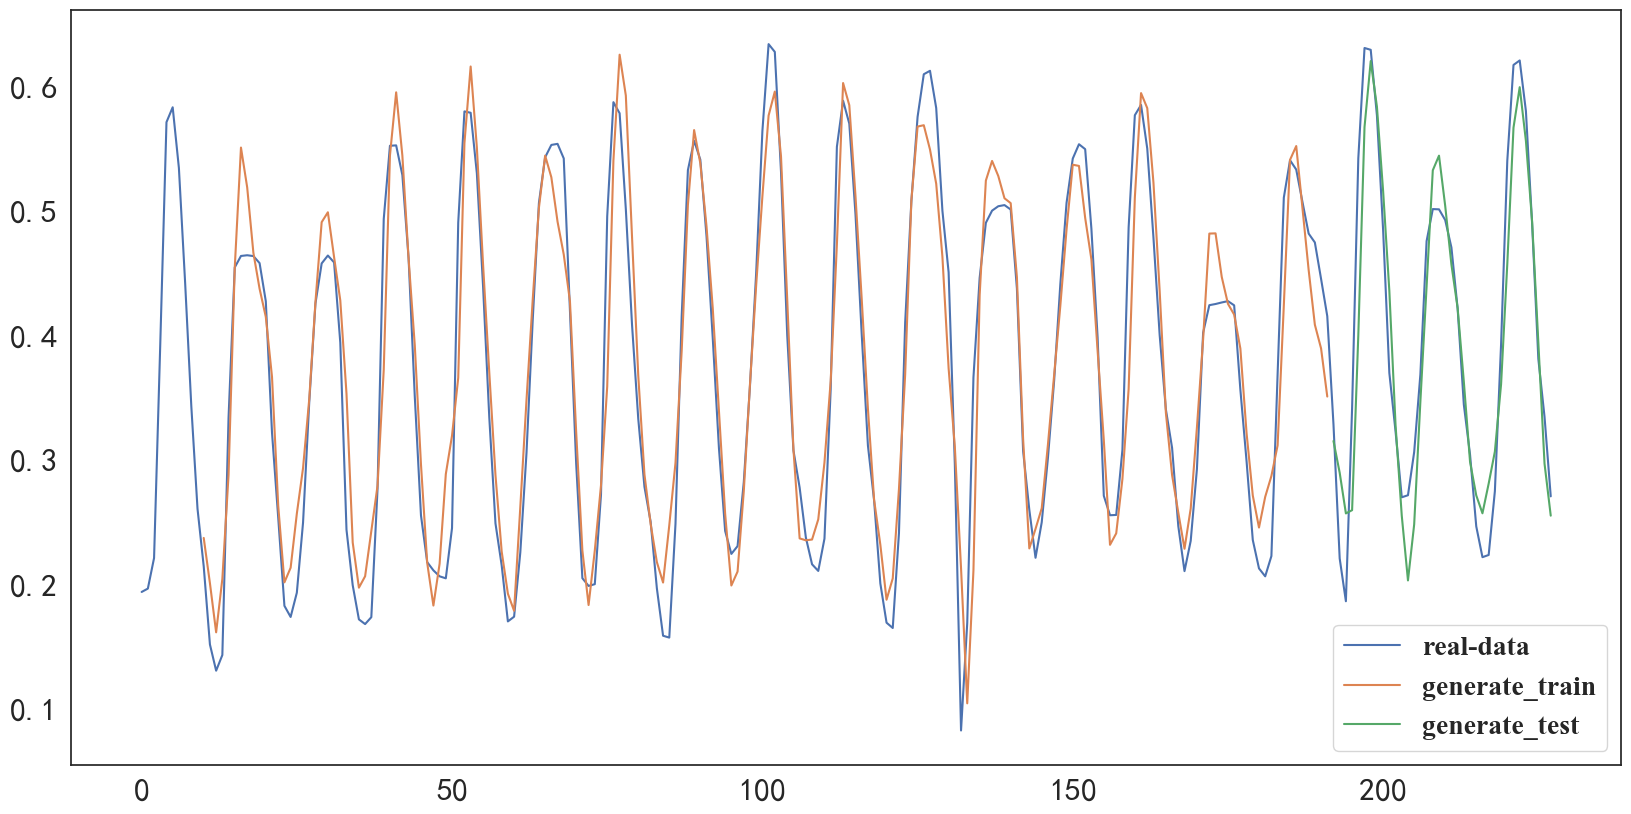

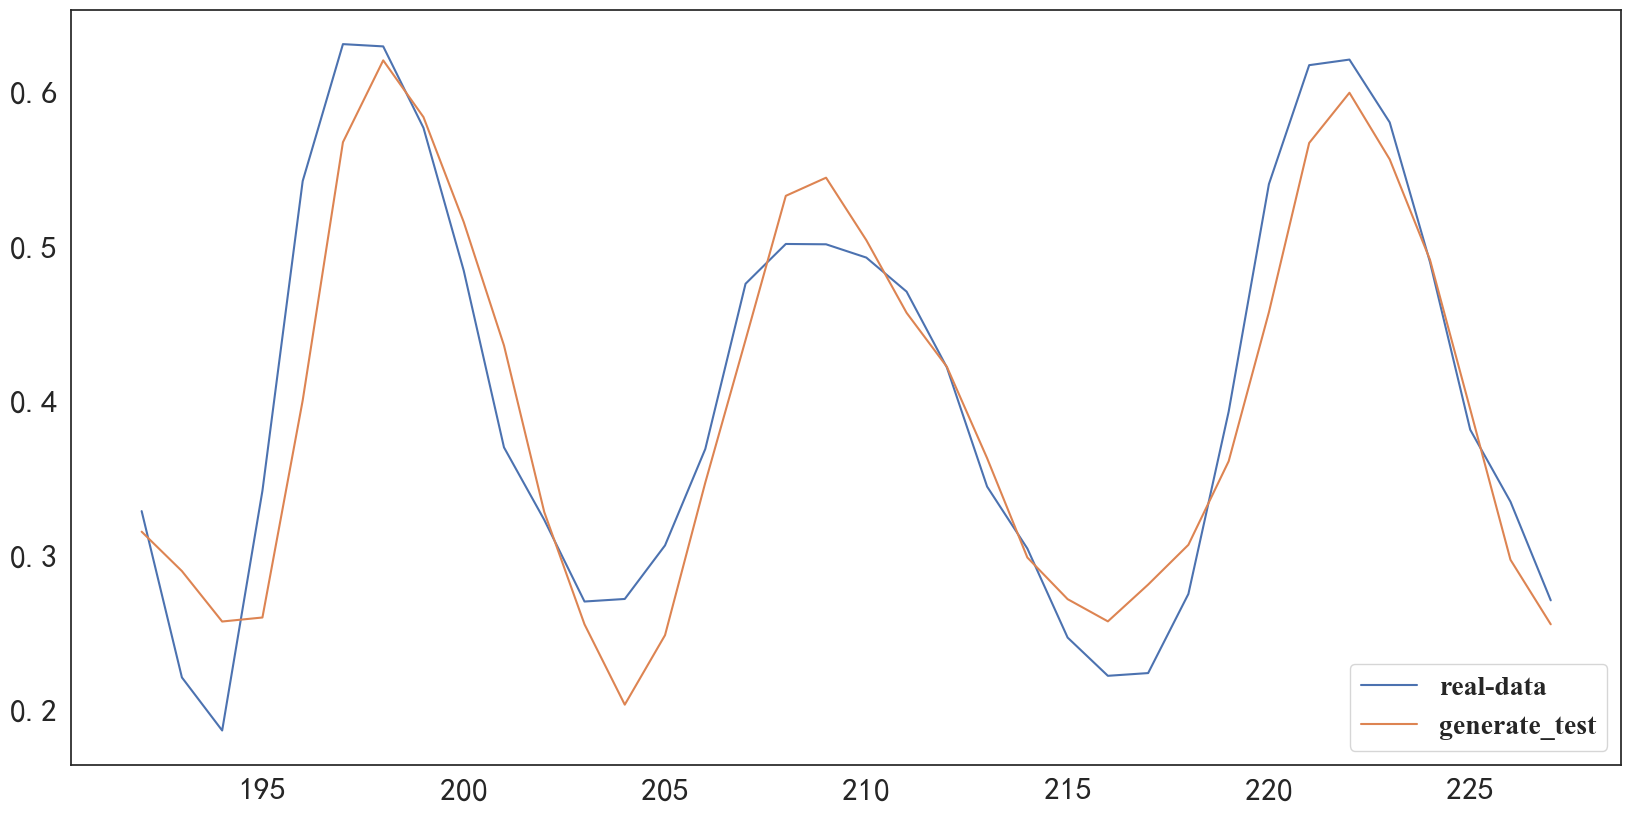

In [9]:
# 画图用的函数
def show(rnn_model):
    train_output = rnn_model(train_data).squeeze(1).detach().numpy()
    
    test_output = rnn_model(test_data).squeeze(1).detach().numpy()  
    read_data = data["EVI值"].copy() 
    X = [x for x in range(data.shape[0])]
    
    plt.figure(figsize=(20 ,10), dpi=100)
    plt.plot(X, read_data, label='real-data')
    plt.plot(X[L:train_size + L], train_output, label='generate_train',)
    plt.plot(X[train_size + L:], test_output, label='generate_test')
    
    plt.tick_params(labelsize=23)
    font = {'family': 'Times New Roman', 'weight': 'normal', 'size':20}
    legend = plt.legend(prop=font)
    
   # plt.legend()
    plt.show()
    
    plt.figure(figsize=(20 ,10), dpi=100)
    plt.cla()
    plt.plot(X[train_size + L:], read_data[train_size + L:], label='real-data')
    plt.plot(X[train_size + L:], test_output, label='generate_test')
    plt.tick_params(labelsize=23)
    font = {'family': 'Times New Roman', 'weight': 'normal', 'size':20}
    legend = plt.legend(prop=font)
    #plt.legend()
    plt.show()
show(rnn)

文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\东安.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\临武.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\临湘.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\临澧.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\会同.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\保靖.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\冷水江.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\冷水滩.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\凤凰.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\华容.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\南县.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\南岳.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\双峰.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\双牌.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\古丈.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\吉首.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\嘉禾.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\城步.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\娄底.xlsx处理完成
文件：E:\170240208TJWBISHE\LSTM\/站点数据统一版\宁乡.xlsx处理完